# **Problem statement: Implementing a specific model trained using Multi-Layer Perceptron and training it on MNIST.fashion dataset for classification of images, i.e, an architecture to process images based on MLPs** 

# **Here we will import the neccessary Libraries:-**

In [1]:
#import my_utils as mu
import torch
import torchvision
from torch import nn
from torch.utils import data
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
import os
import json

# **Invoking functions from my_utils.py files given in Labs 1-3:-** 

In [2]:
# Defined in file: ./chapter_linear-networks/image-classification-dataset.md
def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

# Defined in file: ./chapter_linear-networks/image-classification-dataset.md
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))
    
# Defined in file: ./chapter_preliminaries/calculus.md
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

# Defined in file: ./chapter_preliminaries/calculus.md
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')


# **Loading the required MNIST.fashion Dataset**


In [3]:
#using cuda for graphical processing an approach called general purpose computing on GPUs 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#**Creating the moodel architecture including Stemming and Backbone**

In [4]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, output, f_size, num_outputs): #specifying the required number of patches and feature size(f_size) and output from the backbone will be taken as output
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        #STEM
        self.Unfold = nn.Unfold(patches, padding=0, stride=patches)
        self.Stem = nn.Linear(num_inputs, f_size)

        #BACKBONE
        self.b1 = nn.Sequential (                  # b1= Backbone 1 annd b2 = Backbone 2
            nn.Linear(f_size, output),
            nn.ReLU(),
            nn.Linear(output,  f_size)
        )
       
        self.b2 = nn.Sequential(
            nn.Linear(16, output),
            nn.ReLU(),
            nn.Linear(output, f_size)
        )

        #CLASSIFIER
        self.classifier = nn.Linear(f_size, num_outputs)


    def forward(self, x):
        x = self.Unfold(x)
        x = x.transpose(1,2) 
        feature_matrix = self.Stem(x) 
        x = self.b1(feature_matrix) 
        x = x.transpose(1,2) 
        features = self.b2(x) 
        mean = torch.mean(features, 2)
        out = self.classifier(mean) 
        
        return out 

patches = 7
f_size = 300
output = 256
num_inputs, num_outputs = patches*patches, 10
net = Net(num_inputs, output, f_size,  num_outputs).to(device)
def weight(w):
    if isinstance(w, nn.Linear):
        torch.nn.init.normal_(w.weight, std=0.01)
        torch.nn.init.zeros_(w.bias)

net.apply(weight)
print(net)

Net(
  (Unfold): Unfold(kernel_size=7, dilation=1, padding=0, stride=7)
  (Stem): Linear(in_features=49, out_features=300, bias=True)
  (b1): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=300, bias=True)
  )
  (b2): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=300, bias=True)
  )
  (classifier): Linear(in_features=300, out_features=10, bias=True)
)


# **Specifying the Loss function and the Optimizer**

In [5]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0025) 

In [6]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

In [7]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a __init__ on a dataset."""
    metric = Accumulator(2)  # Passing number of predictions
    for _, (X, y) in enumerate(data_iter):
        X = X.to(device) #Loading dataset to GPU which is in batches
        y = y.to(device) 
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [9]:
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=256, num_outputs=10):  
    """The training function for one epoch."""
    # Set the __init__ to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Computing gradients, updating parameters
        X = X.to(device) 
        y = y.to(device) 
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [10]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(9.5, 4.5)):
      
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
            
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    # Save function 
    def save_image(self, path):
      if not os.path.exists(path):
        os.mkdir(path)
      image_path = path + 'results.png'
      plt.savefig(image_path)

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [11]:
def train_ch3(net, train_iter, test_iter, loss, epochs, optimizer): 
    """Train a __init__."""
    results = {}
    animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.20, 0.95],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)

        # Storing results in format of dictionary
        results["epoch:"+str(epoch + 1)] = {"train acc":train_metrics[1], "test acc": test_acc, "train loss":train_metrics[0]} 
        print(results["epoch:"+str(epoch + 1)])
        animator.add(epoch + 1, train_metrics + (test_acc,))
        
    #Accuracy and loss graph is saved
    animator.save_image('./MNIST_fasion_results/')
    train_loss, train_acc = train_metrics
    print(results)
    return results

#**Training Script for the Model**

{'epoch:1': {'train acc': 0.5928833333333333, 'test acc': 0.702, 'train loss': 1.034165419991811}, 'epoch:2': {'train acc': 0.7612, 'test acc': 0.7839, 'train loss': 0.648444814268748}, 'epoch:3': {'train acc': 0.8087, 'test acc': 0.8124, 'train loss': 0.5381525067647298}, 'epoch:4': {'train acc': 0.8295, 'test acc': 0.8269, 'train loss': 0.47628477447827655}, 'epoch:5': {'train acc': 0.84495, 'test acc': 0.839, 'train loss': 0.43298750553131105}, 'epoch:6': {'train acc': 0.8544, 'test acc': 0.8421, 'train loss': 0.4027998486200968}, 'epoch:7': {'train acc': 0.86525, 'test acc': 0.85, 'train loss': 0.37371743876139324}, 'epoch:8': {'train acc': 0.8690166666666667, 'test acc': 0.8483, 'train loss': 0.3561601803382238}, 'epoch:9': {'train acc': 0.8754166666666666, 'test acc': 0.8604, 'train loss': 0.34077244545618696}, 'epoch:10': {'train acc': 0.8814, 'test acc': 0.8652, 'train loss': 0.3254383753458659}, 'epoch:11': {'train acc': 0.8841333333333333, 'test acc': 0.8699, 'train loss': 0.

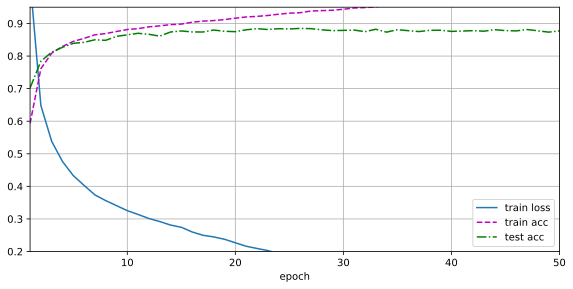

In [12]:
epochs = 50
fn = train_ch3(net, train_iter, test_iter, loss, epochs, optimizer)

with open('results.json', 'w') as fp:
    json.dump(fn, fp)

In [13]:
evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8773